# Notebook for make a modeling focus in reduce churn rate in Telco SA

# Libs

In [41]:
import pandas as pd
import numpy as np
import pickle 

import seaborn as sns
import matplotlib.pylab as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score

from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import ROCAUC

from lazypredict.Supervised import LazyClassifier


# Load - train and valid data

In [2]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

In [3]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\X_valid.pkl', 'rb') as f:
    X_valid = pickle.load(f)

with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\y_valid.pkl', 'rb') as f:
    y_valid = pickle.load(f)

# Overview train

In [4]:
X_train.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
7274-RTAPZ,Male,No,No,No,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,90.55,90.55
5862-BRIXZ,Male,No,No,No,46,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),60.75,2893.40


In [5]:
y_train.head()

customerID
7274-RTAPZ    Yes
5862-BRIXZ     No
5195-KPUNQ     No
2000-DHJUY     No
5847-MXBEO     No
Name: Churn, dtype: object

# Overview valid

In [6]:
X_valid.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
0468-YRPXN,Male,No,No,No,29,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),98.80,2807.10
9944-AEXBM,Male,No,No,No,32,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),85.65,2664.30


In [7]:
y_valid.head()

customerID
0468-YRPXN     No
9944-AEXBM     No
7786-WBJYI    Yes
3679-XASPY     No
9391-YZEJW     No
Name: Churn, dtype: object

# Feature Transform
- Used LabelEncoder in all categorical columns

In [8]:
le = LabelEncoder()

- X_train and X_valid encoder

In [9]:
categorical_cols = X_train.select_dtypes(include=['object']).columns

In [10]:
X_train[categorical_cols] = X_train[categorical_cols].apply(lambda col: le.fit_transform(col))
X_valid[categorical_cols] = X_valid[categorical_cols].apply(lambda col: le.fit_transform(col))

In [11]:
X_train.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
7274-RTAPZ,1,0,0,0,1,1,0,1,0,0,0,0,2,2,0,1,2,90.55,90.55
5862-BRIXZ,1,0,0,0,46,0,1,0,2,0,2,2,2,2,2,1,0,60.75,2893.40


In [12]:
X_valid.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
0468-YRPXN,1,0,0,0,29,1,0,1,0,0,2,2,2,2,0,1,1,98.80,2807.10
9944-AEXBM,1,0,0,0,32,1,2,1,0,0,0,0,0,2,0,1,0,85.65,2664.30


- y_train and y_valid encoder

In [13]:
y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)

In [14]:
y_train

array([1, 0, 0, ..., 0, 1, 1])

In [15]:
y_valid[0:6]

array([0, 0, 1, 0, 0, 0])

# Sanity check - Target encoder
- Churn (Yes) == 1
- Churn (No) == 0

# Testing models - V1
- Using Auto-ML

In [16]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_valid, y_train, y_valid)

100%|██████████| 29/29 [00:08<00:00,  3.31it/s]


In [17]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.72,0.74,0.74,0.74,0.01
QuadraticDiscriminantAnalysis,0.75,0.74,0.74,0.76,0.02
GaussianNB,0.74,0.73,0.73,0.75,0.02
LogisticRegression,0.81,0.72,0.72,0.80,0.04
LinearSVC,0.81,0.72,0.72,0.80,0.15
CalibratedClassifierCV,0.81,0.72,0.72,0.80,0.62
SGDClassifier,0.80,0.72,0.72,0.80,0.03
LinearDiscriminantAnalysis,0.80,0.72,0.72,0.80,0.03
RidgeClassifierCV,0.81,0.72,0.72,0.80,0.02


# Feature Selection
- based with 
- Select LogisticRegression based first better F1 Score

In [18]:
# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [19]:
# feature selection
X_train_fs, X_valid_fs, fs = select_features(X_train, y_train, X_valid)

In [20]:
# what are scores for the features
for i, score in enumerate(fs.scores_):
    print(f'Feature {i}: {score}')

Feature 0: 0.1696622161320032
Feature 1: 112.06437349655629
Feature 2: 71.5659493852574
Feature 3: 113.44625720031391
Feature 4: 13544.491770917784
Feature 5: 0.003265153101115489
Feature 6: 8.182208420502022
Feature 7: 9.737684255595658
Feature 8: 444.417911756446
Feature 9: 192.65887674780765
Feature 10: 158.08892624057347
Feature 11: 433.3240667294018
Feature 12: 8.435063814075514
Feature 13: 6.952955579701721
Feature 14: 897.0285719400724
Feature 15: 86.69222894995391
Feature 16: 53.61067972904575
Feature 17: 2899.9664986961307
Feature 18: 545268.8731358129


In [24]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
7274-RTAPZ,1,0,0,0,1,1,0,1,0,0,0,0,2,2,0,1,2,90.55,90.55
5862-BRIXZ,1,0,0,0,46,0,1,0,2,0,2,2,2,2,2,1,0,60.75,2893.40
5195-KPUNQ,0,1,0,0,53,1,0,1,2,2,0,2,0,2,1,1,3,96.75,5206.55
2000-DHJUY,0,1,1,0,70,1,2,0,2,2,2,2,2,2,2,1,0,92.20,6474.45
5847-MXBEO,1,0,0,0,22,1,0,2,1,1,1,1,1,1,1,0,3,20.30,475.10


- Features to remove because feature selection
    - gender
    - PhoneService

In [25]:
X_train = X_train.drop(['gender','PhoneService'], axis=1)

In [26]:
X_valid = X_valid.drop(['gender','PhoneService'], axis=1)

# Testing models - V2

In [27]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_valid, y_train, y_valid)

100%|██████████| 29/29 [00:07<00:00,  3.65it/s]


In [28]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.72,0.75,0.75,0.74,0.01
SGDClassifier,0.79,0.73,0.73,0.79,0.03
GaussianNB,0.74,0.73,0.73,0.75,0.01
QuadraticDiscriminantAnalysis,0.74,0.72,0.72,0.75,0.02
LogisticRegression,0.80,0.72,0.72,0.80,0.03
LinearDiscriminantAnalysis,0.80,0.72,0.72,0.80,0.04
RidgeClassifierCV,0.81,0.72,0.72,0.80,0.02
LinearSVC,0.80,0.72,0.72,0.80,0.26
CalibratedClassifierCV,0.80,0.71,0.71,0.80,0.62


# Select and train a model - based F1 Score
- Select LogisticRegression based first better F1 Score

In [32]:
def fit_model(X_train, y_train):
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train, y_train)
    return clf

In [33]:
clf = fit_model(X_train, y_train)

In [34]:
clf

LogisticRegression(class_weight='balanced')

## Eval model valid set

In [37]:
def eval_model(clf, X_valid, y_valid):
    y_proba = clf.predict_proba(X_valid)[:, 1]
    y_pred = clf.predict(X_valid)
    
    return {
        'roc_auc': roc_auc_score(y_valid, y_proba),
        'average_precision': average_precision_score(y_valid, y_proba),
        'accuracy': accuracy_score(y_valid, y_pred),
        'precision': precision_score(y_valid, y_pred),
        'recall': recall_score(y_valid, y_pred),
        'f1': f1_score(y_valid, y_pred),
    }

In [38]:
eval_model(clf, X_valid, y_valid)

{'roc_auc': 0.8327012665983542,
 'average_precision': 0.6040613857944706,
 'accuracy': 0.7301136363636364,
 'precision': 0.48464163822525597,
 'recall': 0.7845303867403315,
 'f1': 0.5991561181434599}

## Use cross validation eval model

In [40]:
# Instaciando a classe do modelo  
Logit = LogisticRegression(C=0.1,
                           random_state=42,
                           max_iter=300, 
                           class_weight="balanced")
 
# Treina os modelos 
Logit.fit(X_train, y_train)
        
# Faz predições
y_pred = Logit.predict(X_valid)
 
# Validação cruzada estratificada
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        
# Validação cruzada pela métrica f1_score, (nos dados de validação/teste) 
f1 = cross_val_score(Logit, X_valid, y_valid, scoring="f1", cv=skfold, n_jobs=-1)
 
# métrica área sob a curva de característica de operação do receptor
auc = roc_auc_score(y_valid, y_pred)
 
#Exibe as métricas 
print(f"{Logit}",end="\n\n")
print(f" f1_Score_CV:{f1.mean():.3f} STD: {f1.std():.2f}, AUC: {auc:.3f}",end="\n\n")

LogisticRegression(C=0.1, class_weight='balanced', max_iter=300,
                   random_state=42)

 f1_Score_CV:0.593 STD: 0.07, AUC: 0.752



## Visualize eval model

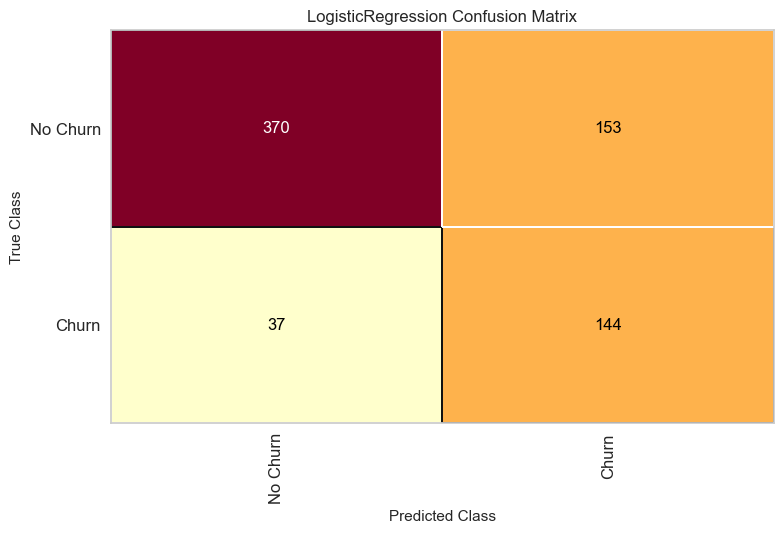

<Figure size 800x550 with 0 Axes>

In [43]:
mapping = {0:"No Churn",1:"Churn"}

confusion_matrix(
    Logit,
    X_train, y_train, X_valid, y_valid,
    classes=['No Churn', 'Churn'],
    label_encoder=mapping
)
plt.tight_layout()

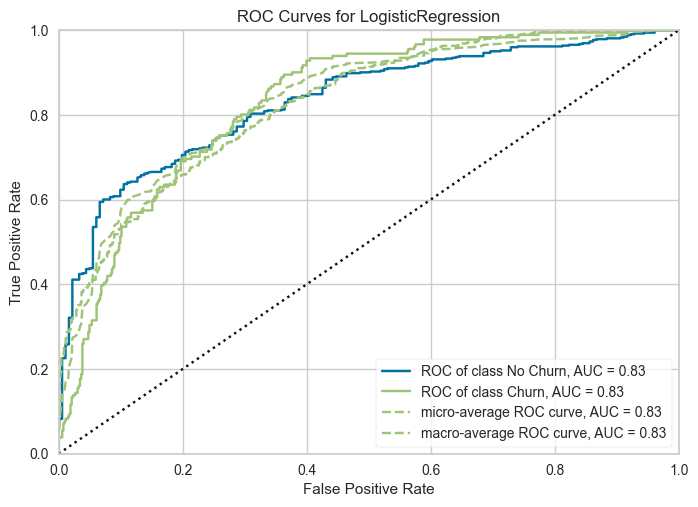

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [44]:
visualizer = ROCAUC(Logit, classes=["No Churn", "Churn"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_valid, y_valid)        
visualizer.show() 

# Optmize model

# Model eval test set

# Business performance

# Next steps - Deploy